In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt 
from matplotlib import image
import random as rd
import math as m
from PIL import Image


import requests as req
import npzviewer
import wget
from bs4 import BeautifulSoup
import csv

import os
print(os.getcwd())

#from google.cloud import storage
#client = storage.Client()
import copy
#pip install --user google-cloud-storage

/Users/babi/Documents/GitHub/Quickdraw1/training_quickdraw


In [138]:
##########

In [10]:
def download_data(categories,number_of_samples):

    data = np.array([], dtype=np.int64).reshape(0,784)
    for i in range(len(categories)):
        filename = cats[i][0] + '.npy'
        filename = filename.replace(" ","%20")
        
        url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'+filename
        
        r = req.get(url, allow_redirects=True)
        #filename = os.path.basename(url)
        #filename = filename.replace("%20","")
        open(filename, 'wb').write(r.content)
        
        data = np.vstack([data,load_data(filename,number_of_samples)])
        
        os.remove(filename)
        print(i+1,'/',number_of_samples,' ',filename.replace("%20",""))
    return data

def load_data(name,n):
    filename = name
    label = name
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    return data[0:n,:]

#randomize data and labels
def randomize_data(data,labels,seed):
    np.random.seed(seed)
    np.random.shuffle(data)
    np.random.seed(seed)
    np.random.shuffle(cat_id)

In [3]:
#load categories
cats = open("categories.txt",'r')
reader = csv.reader(cats)
cats = [row for row in reader]

#load data
number_of_categories = len(cats)
number_of_samples = 30000

d = download_data(cats[0:number_of_categories],number_of_samples)
cat_id = np.repeat(range(number_of_categories),number_of_samples)+1

#reshape data into 28x28
data = d.copy()
data = np.reshape(data,(len(d),28,28))


1   aircraftcarrier.npy
2   airplane.npy
3   alarmclock.npy


In [ ]:
#randomize data and cat_id
randomize_data(data,cat_id,3)

['alarm clock'] 5074


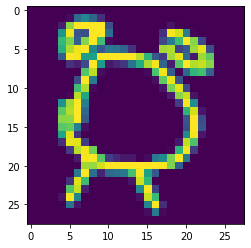

In [4]:
#TEST Show
i=rd.randint(1,number_of_categories*number_of_samples)
plt.imshow(data[i])
print(cats[cat_id[i]-1],i)

In [5]:
#split data
training = 0.8
test = 1.-training

x_train = data[0:m.floor(training*len(data))]/ 255.0
y_train = cat_id[0:m.floor(training*len(cat_id))]

x_test = data[m.ceil(training*len(data)):len(data)]/ 255.0
y_test = cat_id[m.ceil(training*len(cat_id)):len(cat_id)]

print('Train-Set: ','Samples',np.shape(x_train)[0])
print('Test-Set: ','Samples',np.shape(x_test)[0])

Train-Set:  Samples 24000
Test-Set:  Samples 6000


In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5),
  tf.keras.layers.Softmax()
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [8]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20)

Epoch 1/20
750/750 [==============================] - 2s 2ms/step - loss: 1.1583 - accuracy: 0.7490
Epoch 2/20
750/750 [==============================] - 2s 2ms/step - loss: 1.0936 - accuracy: 0.8125
Epoch 3/20
750/750 [==============================] - 2s 2ms/step - loss: 1.0734 - accuracy: 0.8322
Epoch 4/20
750/750 [==============================] - 1s 2ms/step - loss: 1.0561 - accuracy: 0.8503
Epoch 5/20
750/750 [==============================] - 2s 2ms/step - loss: 1.0508 - accuracy: 0.8559
Epoch 6/20
750/750 [==============================] - 2s 3ms/step - loss: 1.0450 - accuracy: 0.8607
Epoch 7/20
750/750 [==============================] - 2s 2ms/step - loss: 1.0359 - accuracy: 0.8709
Epoch 8/20
750/750 [==============================] - 1s 2ms/step - loss: 1.0337 - accuracy: 0.8734
Epoch 9/20
750/750 [==============================] - 1s 2ms/step - loss: 1.0270 - accuracy: 0.8789
Epoch 10/20
750/750 [==============================] - 1s 2ms/step - loss: 1.0281 - accuracy: 0.8775

In [9]:
model.evaluate(x_test,  y_test, verbose=2);

188/188 - 0s - loss: 1.0488 - accuracy: 0.8562


In [43]:
name = "qd.h5"
saved_model_dir = 'save/'+str(name)
model.save(saved_model_dir)
print('Model Saved to '+saved_model_dir)

Model Saved to save/qd.h5


In [ ]:
#tf.saved_model.save(model,'save/')
#converter = tf.lite.TFLiteConverter.from_keras_model_file(model)
#Use this if 238 fails 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/jh/06wb5xgj6vj48hhfwmc8d_rc0000gn/T/tmp0wyva6sv/assets


In [17]:
model.save('save/qd_0')


INFO:tensorflow:Assets written to: save/qd_0/assets


In [44]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
_________________________________________________________________
softmax_3 (Softmax)          (None, 5)                 0         
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________


In [22]:
new_model = tf.keras.models.load_model('save/qd_0')
new_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________


In [28]:
new_model.evaluate(x_test,  y_test, verbose=2);


4198/4198 - 4s - loss: 0.9522 - accuracy: 0.9523


In [26]:
predictions = new_model.predict(x_test)

airplane


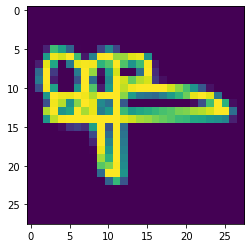

In [27]:
i=2
print(labels[np.argmax(predictions[i])])
plt.figure()
plt.imshow(x_test[i])
plt.show()

(1200, 1200, 4)


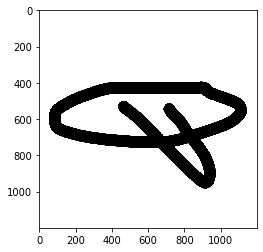

In [29]:
#Show PNG
image = Image.open('dataset/airplane3.png')
# convert image to numpy array
data = asarray(image)
data = abs(data-255.)/255.

# summarize shape
print(data.shape)
plt.imshow(image)
plt.show()



airplane
(1, 28, 28)


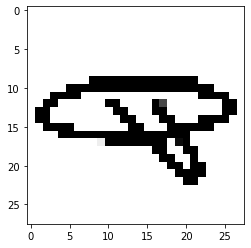

In [30]:
#Convert png to 28x28 array
image = Image.open('dataset/airplane3.png')
image_resize = image.resize((28,28))
data_resize = asarray(image_resize)
data_resize = abs(data_resize-255.)/255.
data_resize = data_resize[:, :, 0]
data_resize = np.expand_dims(data_resize, axis=0)

#Predict png
predictions = new_model.predict(data_resize)
print(labels[np.argmax(predictions)])
print(data_resize.shape)
plt.imshow(image_resize)
plt.show()
